In [17]:
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

In [18]:
class PAdicNetwork(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim):
        super().__init__()
        self.linear_stack=torch.nn.Sequential(
            torch.nn.Linear(input_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,1)
        )
    def forward(self,input_x):
        return self.linear_stack(input_x)
        
def loss_function(Solution,Predicted):
    losses=torch.exp(((Solution-Predicted)**2)/5)-1
    return losses.mean()

In [19]:
# ------------------------------------------------------------
# Extended Euclidean Algorithm
# ------------------------------------------------------------
def Extended_Euclidean_Recursive(a, b):
    if b == 0:
        return a, 1, 0
    g, x1, y1 = Extended_Euclidean_Recursive(b, a % b)
    return g, y1, x1 - (a // b) * y1

# ------------------------------------------------------------
# p-adic valuation
# ------------------------------------------------------------
def v_p(n, p):
    n = abs(n)
    k = 0
    while n % p == 0 and n != 0:
        n //= p
        k += 1
    return k

# ------------------------------------------------------------
# Positive p-adic expansion (handles denominators divisible by p)
# digits are least-significant first
# ------------------------------------------------------------
def p_expansion_positive(r, s, p, n, *, report=False):
    """
    Compute the p-adic expansion digits of x = r/s (r,s>0) up to n digits.
    Handles denominators divisible by p. If report=True, prints any valuation shift.
    """
    # factor out powers of p from r and s
    v_r = v_p(r, p)
    v_s = v_p(s, p)
    shift = v_r - v_s            # overall power of p (v_p(x))
    r_ = r // (p ** v_r)
    s_ = s // (p ** v_s)

    # s_ now coprime to p
    x = Fraction(r_, s_)
    digits = []
    s_partial = Fraction(0, 1)
    f_prev = x

    for i in range(n):
        r_i = f_prev.numerator
        s_i = f_prev.denominator

        g, u, _ = Extended_Euclidean_Recursive(s_i % p, p)
        if g != 1:
            raise ValueError("Denominator not invertible mod p.")
        u %= p

        # a_i = ((r_i mod p)*(s_i^{-1} mod p)) mod p
        a_i = ((r_i % p) * u) % p
        digits.append(a_i)

        # update next fractional term
        s_partial = s_partial + Fraction(a_i * (p ** i), 1)
        f_prev = (x - s_partial) / (p ** (i + 1))

    # apply valuation shift and REPORT it
    if shift > 0:
        if report:
            print(f"[shift] v_p(x) = {shift} ⇒ prepending {shift} zero digit(s).")
        digits = ([0] * shift + digits)[:n]
    elif shift < 0:
        if report:
            print(f"[shift] v_p(x) = {shift} ⇒ series starts at power p^{shift} (negative index).")
            
    return digits, shift

# ------------------------------------------------------------
# General p-adic expansion with correct negative handling
# ------------------------------------------------------------
def p_expansion(r, s, p, n):
    if r == 0:
        return [0]*n,0

    neg = (r < 0) ^ (s < 0)
    r_abs, s_abs = abs(r), abs(s)

    pos,shift = p_expansion_positive(r_abs, s_abs, p, n)
    if not neg:
        return pos,shift

    # find first nonzero digit index k
    k = None
    for i, d in enumerate(pos):
        if d % p != 0:
            k = i
            break

    neg_digits = [0]*n
    if k is None:
        # |x| ≡ 0 mod p^n ⇒ -x also ≡ 0 mod p^n
        return neg_digits,shift 

    for i in range(n):
        if i < k:
            neg_digits[i] = 0                         # *** FIX: was p-1
        elif i == k:
            neg_digits[i] = (p - pos[i]) % p
        else:
            neg_digits[i] = (p - 1 - pos[i]) % p

def p_adic_integer(a, b, p, n):
    digits, shift = p_expansion(a, b, p, n)
    dim = len(digits)
    if shift < 0:
        return 'No Modular defined'
    elif shift >= 0:
        coefficients = []
        for i in range(0, dim+1):
            coefficients.append((p**i))
        integer = sum(a * c for a, c in zip(digits, coefficients))
        return integer

In [20]:
def Generate_Dataset(p,range_valuation,n_samples,precision):
    samples = []
    samples_scalar=[]
    solutions = []
    samples_every_valuation = n_samples // (range_valuation + 1)
    for v in range(range_valuation + 1):
        for _ in range(samples_every_valuation):
            # 1. Generate a Random Unit (a/b)
            # We pick random integers a, b such that they are NOT divisible by p
            a = np.random.randint(1, 100)
            b = np.random.randint(1, 100)
            
            # Reject if divisible by p (Enforce Unit property)
            while a % p == 0: a = np.random.randint(1, 100)
            while b % p == 0: b = np.random.randint(1, 100)
            
            # 2. Construct the p-adic number: p^v * (a/b)
            # This places the number exactly at depth 'v' in the p-adic tree
            val_term = p ** v
            rational_x = Fraction(a, b) * val_term
            samples_scalar.append(rational_x)
            try:
                x=p_adic_integer(a=rational_x.numerator, b=rational_x.denominator, p=p, n=precision)
                x_vector = [np.sin(np.pi * x / (p**k))**2 for k in range(1, precision + 1)]
                samples.append(x_vector)
                solutions.append(v)
            except:
                print("one sample generation failed due to coprime")
                continue
    return samples_scalar,samples,solutions

In [21]:
p=3
precision=14
range_valuation=5
n_samples=1100
samples_scalar,samples,solutions=Generate_Dataset(p=p,range_valuation=range_valuation,n_samples=n_samples,precision=precision)
from sklearn.model_selection import train_test_split
(
    input_train,
    input_test,
    output_train,
    output_test,
    scalar_train,
    scalar_test,
)=train_test_split(samples,solutions,samples_scalar,train_size=0.9)
from sklearn.utils import shuffle
input_train,output_train=shuffle(input_train,output_train)
input_train=torch.tensor(input_train,dtype=torch.float32)
output_train=torch.tensor(output_train,dtype=torch.float32)
input_test=torch.tensor(input_test,dtype=torch.float32)
output_test=torch.tensor(output_test,dtype=torch.float32)
output_train=torch.unsqueeze(output_train,1)

In [22]:
max_training=1000
losses=[]
model=PAdicNetwork(precision,700)
step=1e-3
optim=torch.optim.Adam(model.parameters(),lr=step)
for i in range (0,max_training-1):
    optim.zero_grad()
    predicted=model.forward(input_train)
    loss=loss_function(output_train,predicted)
    losses.append(loss.item())
    loss.backward()
    optim.step()
    if loss<0.001:
        break

The mean square error is 0.009179399


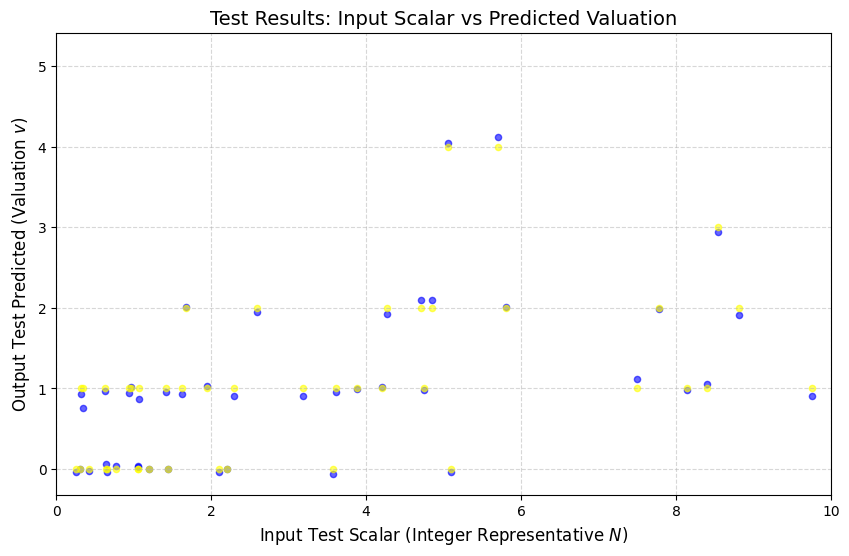

In [45]:
output_test_predicted=model(input_test)
output_test_predicted=output_test_predicted.detach().numpy()
mse = np.mean((output_test_predicted.flatten() - output_test.detach().numpy().flatten())**2)
plt.figure(figsize=(10, 6))
plt.scatter(scalar_test, output_test_predicted, color='blue', alpha=0.6, s=20)
plt.scatter(scalar_test, output_test, color='yellow', alpha=0.6, s=20)
plt.title("Test Results: Input Scalar vs Predicted Valuation", fontsize=14)
plt.xlabel("Input Test Scalar (Integer Representative $N$)", fontsize=12)
plt.ylabel("Output Test Predicted (Valuation $v$)", fontsize=12)
plt.xlim([0,10])
plt.grid(True, linestyle='--', alpha=0.5)
print("The mean square error is",mse)

The mean square error is 0.0048121875


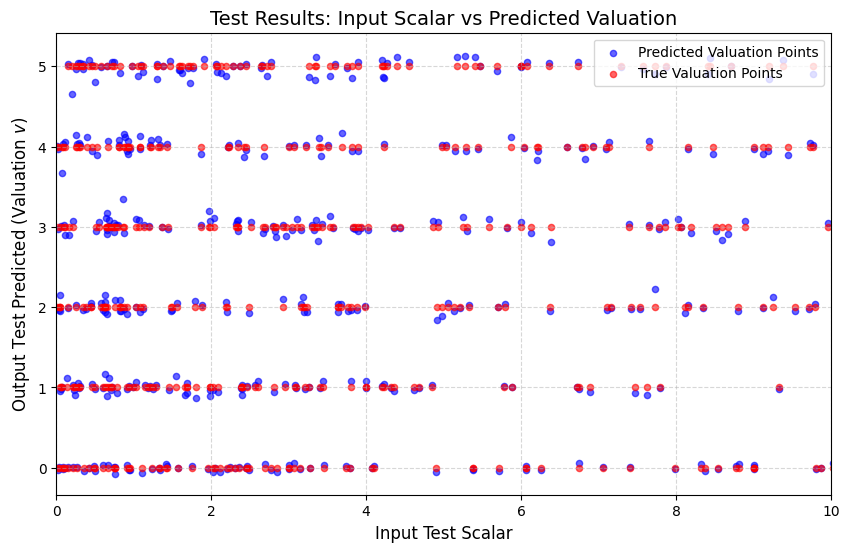

In [113]:
output_train_predicted=model(input_train)
output_train_predicted=output_train_predicted.detach().numpy()
mse = np.mean((output_train_predicted.flatten() - output_train.detach().numpy().flatten())**2)
plt.figure(figsize=(10, 6))
plt.scatter(scalar_train, output_train_predicted, color='blue', alpha=0.6, s=20,label='Predicted Valuation Points')
plt.scatter(scalar_train, output_train, color='red', alpha=0.6, s=20,label='True Valuation Points')
plt.legend(loc='upper right', frameon=True)
plt.title("Test Results: Input Scalar vs Predicted Valuation", fontsize=14)
plt.xlabel("Input Test Scalar", fontsize=12)
plt.ylabel("Output Test Predicted (Valuation $v$)", fontsize=12)
plt.xlim([0,10])
plt.grid(True, linestyle='--', alpha=0.5)
print("The mean square error is",mse)

In [115]:
def Generate_Testing_Dataset(p,range_valuation,n_samples,precision):
    samples = []
    samples_scalar=[]
    solutions = []
    samples_every_valuation = n_samples // (range_valuation + 1)
    for v in range(range_valuation + 1):
        for _ in range(samples_every_valuation):
            # 1. Generate a Random Unit (a/b)
            # We pick random integers a, b such that they are NOT divisible by p
            a = np.random.randint(100,200)
            b = np.random.randint(100,200)
            
            # Reject if divisible by p (Enforce Unit property)
            while a % p == 0: a = np.random.randint(1, 100)
            while b % p == 0: b = np.random.randint(1, 100)
            
            # 2. Construct the p-adic number: p^v * (a/b)
            # This places the number exactly at depth 'v' in the p-adic tree
            val_term = p ** v
            rational_x = Fraction(a, b) * val_term
            samples_scalar.append(rational_x)
            try:
                x=p_adic_integer(a=rational_x.numerator, b=rational_x.denominator, p=p, n=precision)
                x_vector = [np.sin(np.pi * x / (p**k))**2 for k in range(1, precision + 1)]
                samples.append(x_vector)
                solutions.append(v)
            except:
                print("one sample generation failed due to coprime")
                continue
    return samples_scalar,samples,solutions

66.47997839750292


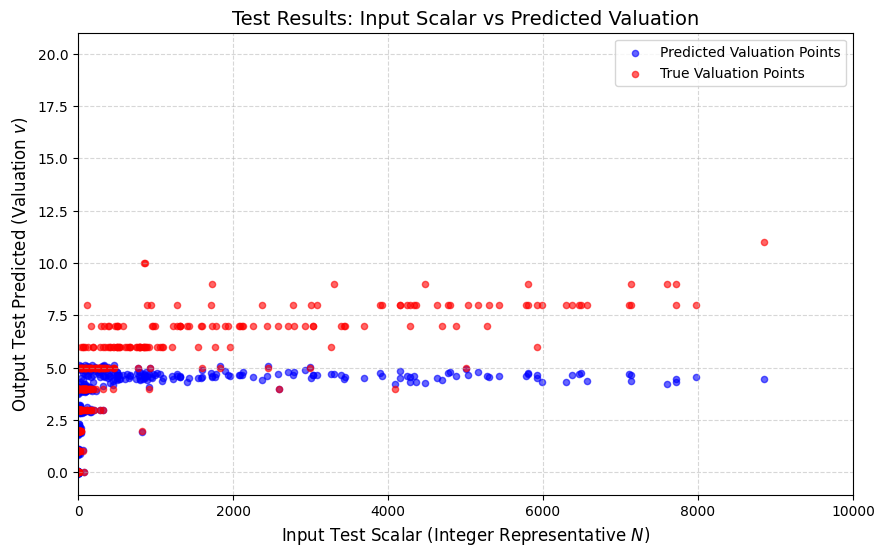

In [119]:
testing_dataset_scalar,testing_dataset,testing_solutions=Generate_Testing_Dataset(p=p,range_valuation=20,n_samples=n_samples,precision=precision)
testing_dataset=torch.tensor(testing_dataset,dtype=torch.float32)
testing_predicted=model(testing_dataset)
mse = np.mean((testing_predicted.detach().numpy().flatten() - testing_solutions)**2)
plt.figure(figsize=(10, 6))
plt.scatter(testing_dataset_scalar, testing_predicted.detach().numpy(), color='blue', alpha=0.6, s=20,label='Predicted Valuation Points')
plt.scatter(testing_dataset_scalar, testing_solutions, color='red', alpha=0.6, s=20,label='True Valuation Points')
plt.title("Test Results: Input Scalar vs Predicted Valuation", fontsize=14)
plt.xlabel("Input Test Scalar (Integer Representative $N$)", fontsize=12)
plt.ylabel("Output Test Predicted (Valuation $v$)", fontsize=12)
plt.xlim([0,10000])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', frameon=True)
print('The mean square error is', mse)